# Automated Face Detection & Morphing

## Setup

In [226]:
import delaunay
import cv2
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from scipy.spatial import Delaunay
import warping
import cross_dissolve
import facial_detection
reload(facial_detection)

<module 'facial_detection' from '/Users/sonalimerchia/Desktop/CS445/FinalProject/facial_detection.py'>

## Face detection in images

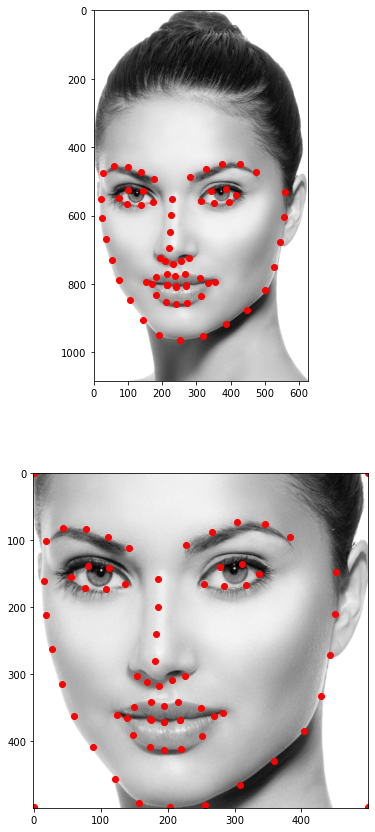

In [248]:
# Get initial large image to show
image = cv2.cvtColor(cv2.imread("case_2_1.png"), cv2.COLOR_BGR2GRAY)
bounds = facial_detection.get_face_bounds(image)[0]
keypoints_big = facial_detection.get_facial_landmarks(image, bounds)

# Use shorthand version to get all facial detection data in one call
keypoints_cropped, cropped_face, bounds = facial_detection.detect_face("case_2_1.png")

fig, axes = plt.subplots(2)
fig.set_figheight(15)

axes[0].imshow(image, cmap='gray')
for [x, y] in keypoints_big:
    axes[0].plot(x, y, 'ro')
    
axes[1].imshow(cropped_face, cmap='gray')
for [x, y] in keypoints_cropped:
    axes[1].plot(x, y, 'ro')

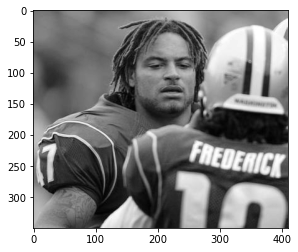

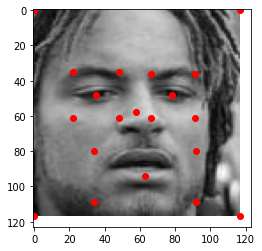

In [249]:
image = cv2.cvtColor(cv2.imread('img_341.jpg'), cv2.COLOR_BGR2GRAY)
faces = delaunay.detect_faces(image)
face_images = delaunay.crop_faces([image], [(0, *face) for face in faces])
keypoints = delaunay.get_face_keypoints(face_images)
plt.figure()
plt.imshow(image, cmap='gray')
for face_image, feature_points in zip(face_images, keypoints):
    if feature_points is None:
        continue
    plt.figure()
    plt.imshow(face_image, cmap='gray')
    for (x, y) in feature_points:
        plt.plot(x, y, 'ro')
plt.show()

### SSD vs. previously tagged faces (TODO)

## Delaunay Algorithm

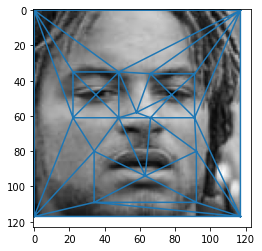

In [250]:
triangulations = delaunay.create_triangulations(keypoints)

for face_image, feature_points, triangulation in zip(face_images, keypoints, triangulations):
    if triangulation is None:
        continue
    plt.figure()
    plt.imshow(face_image, cmap='gray')
    plt.triplot(feature_points[:, 0], feature_points[:, 1], triangulation)
plt.show()

## Interpolate the triangulations

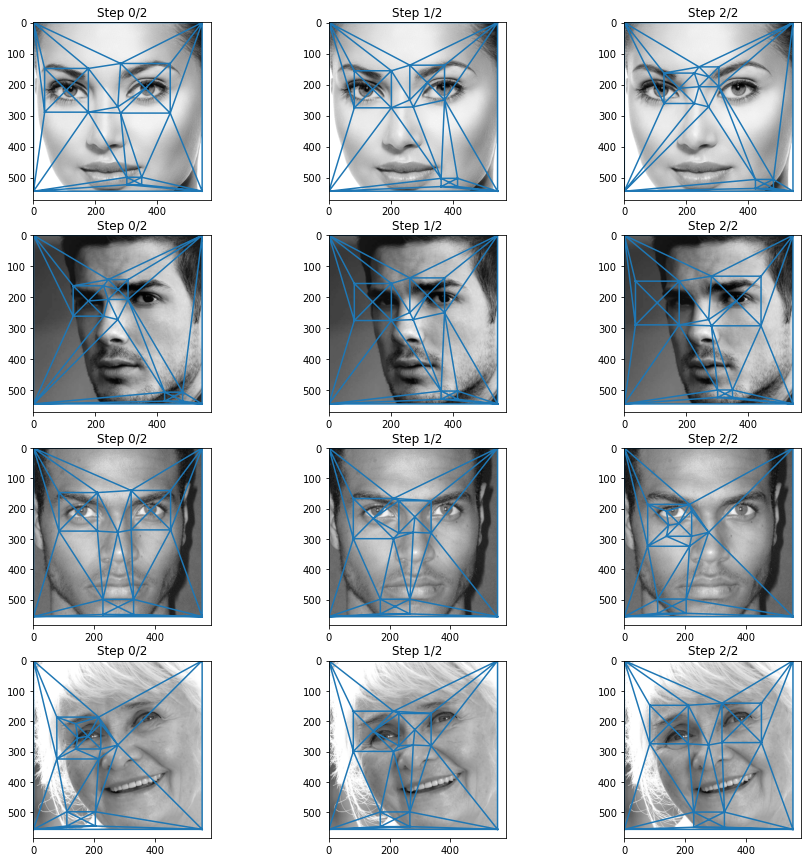

In [251]:
def get_image(file):
    return cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY)

def get_face(args):
    i, image = args
    faces = delaunay.detect_faces(image)
    assert len(faces) > 0
    return (i, *faces[0])

num_interpolations = 2
test_case_images = [
    ("case_2_1.png", "case_2_2.jpeg"),
    ("case_3_1.jpeg", "case_1_2.png"),
]

fig, ax = plt.subplots(len(test_case_images) * 2, num_interpolations + 1)
fig.set_figwidth(15)
fig.set_figheight(15)
for test_case_index, files in enumerate(test_case_images):
    images = list(map(get_image, files))
    faces = list(map(get_face, enumerate(images)))
    cropped_faces = delaunay.crop_faces(images, faces)
    keypoints = delaunay.get_face_keypoints(cropped_faces)
    interpolations = delaunay.interpolate_triangulations(*keypoints, num_interpolations=num_interpolations)


    for image_index, (image, interpolation) in enumerate(zip(cropped_faces, interpolations)):
        for time_index, interpolated in enumerate(interpolation):
            relevant_ax = ax[test_case_index * 2 + image_index, time_index]
            relevant_ax.set_title("Step " + str(time_index) + "/" + str(num_interpolations))
            relevant_ax.imshow(image, cmap='gray')
            relevant_ax.triplot(interpolated[0][:, 0], interpolated[0][:, 1], interpolated[1])
            
plt.show()

## Warp both images

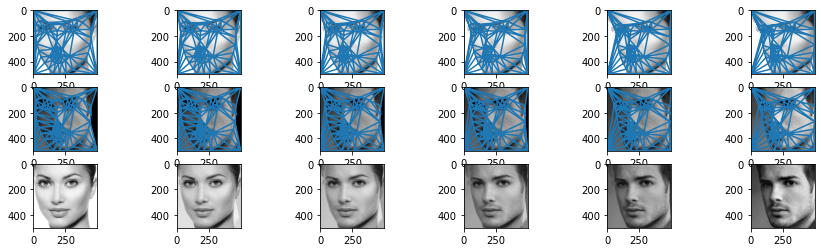

In [309]:
# Load images
keypoints1, cropped_face1, _ = facial_detection.detect_face("case_2_1.png")
keypoints2, cropped_face2, _ = facial_detection.detect_face('case_2_2.jpeg')

num_interpolations = 5

# Determine point locations at each time step
(im1inters, im2inters) = delaunay.interpolate_triangulations(keypoints1, keypoints2, num_interpolations=num_interpolations)
morph =  np.zeros((num_interpolations + 1, *cropped_face1.shape))
morph[0] = cropped_face1
morph[-1] = cropped_face2

fig, ax = plt.subplots(3, num_interpolations + 1)
fig.set_figwidth(15)

# Plot initial images
ax[0, 0].imshow(cropped_face1, cmap='gray')
ax[0, 0].triplot(keypoints1[:, 0], keypoints1[:, 1], im1inters[0][1])
ax[1, -1].imshow(cropped_face2, cmap='gray')
ax[1, -1].triplot(keypoints2[:, 0], keypoints2[:, 1], im2inters[0][1])

simplexes_im1 = im1inters[0][1]
simplexes_im2 = im2inters[0][1]

for time_idx in range(1, num_interpolations+1): 
    final_pts_im1 = im1inters[time_idx][0]
    final_pts_im2 = im2inters[time_idx][0]

    # warp images
    out_img1, _ = warping.get_morphed_image(keypoints1, final_pts_im1, simplexes_im1, cropped_face1)
    out_img2, _ = warping.get_morphed_image(keypoints2, final_pts_im2, simplexes_im2, cropped_face2)

    # Plot them with their triangulations
    ax[0, time_idx].imshow(out_img1, cmap='gray')
    ax[0, time_idx].triplot(final_pts_im1[:, 0], final_pts_im1[:, 1], simplexes_im1)
    ax[1, num_interpolations-time_idx].imshow(out_img2, cmap='gray')
    ax[1, num_interpolations-time_idx].triplot(final_pts_im2[:, 0], final_pts_im2[:, 1], simplexes_im2)
    
    # Mini mixing to show approximately what combination will look like
    morph[time_idx] += out_img1*(1-0.2*time_idx)
    morph[num_interpolations-time_idx] += out_img2*(0.2*(num_interpolations-time_idx))
    
for time_idx in range(num_interpolations+1): 
    ax[2, time_idx].imshow(morph[time_idx], cmap='gray')

## Cross-dissolve the colors

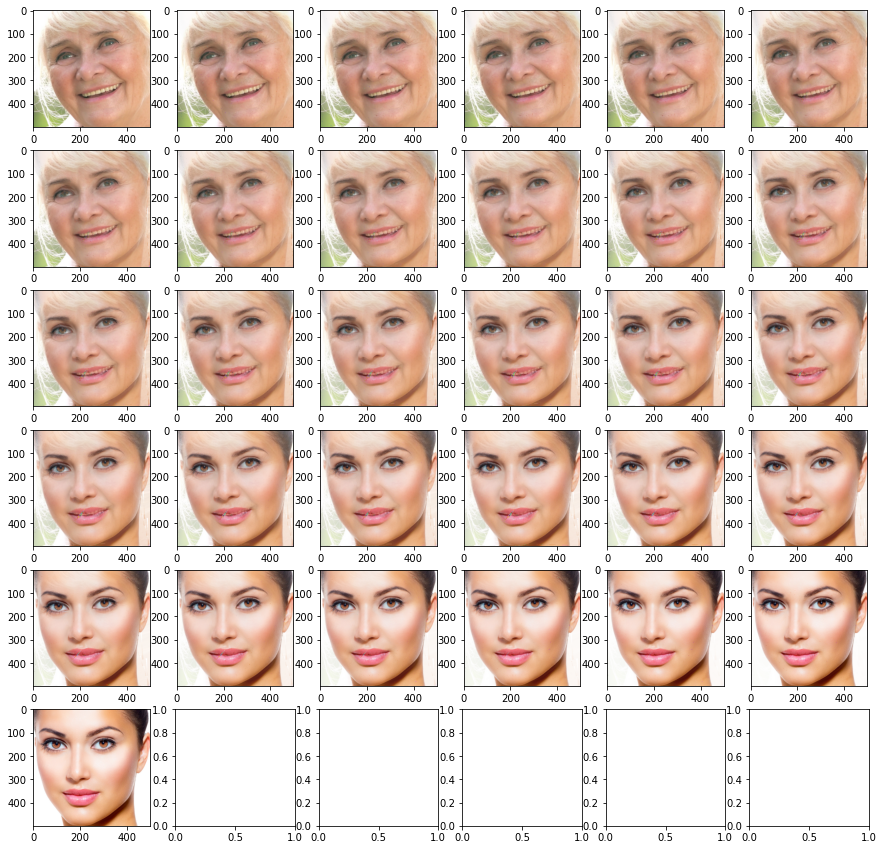

In [366]:
reload(cross_dissolve)

num_interpolations = 30

im1_name = "case_1_2.png"
im2_name = 'case_2_1.png'

# Load images
keypoints1, cropped_face1, bounds1 = facial_detection.detect_face(im1_name)
keypoints2, cropped_face2, bounds2 = facial_detection.detect_face(im2_name)
interpolation = delaunay.interpolate_triangulations(keypoints1, keypoints2, num_interpolations=num_interpolations)

# Get color images
image1 = cv2.imread(im1_name)
image2 = cv2.imread(im2_name)
cropped_face1 = facial_detection.recrop(image1, *bounds1)
cropped_face2 = facial_detection.recrop(image2, *bounds2)

# Get cross dissolved progression
image_progression = cross_dissolve.dissolve(*interpolation, [cropped_face1, cropped_face2])

# Plot images
fig, axes = plt.subplots(6, 6)
fig.set_figwidth(15)
fig.set_figheight(15)
for image_idx, image in enumerate(image_progression): 
    axes[image_idx // 6, image_idx % 6].imshow(image[:, :, [2, 1, 0]])

## Create video

In [371]:
! python3 morphing_video.py -d=images/ -f=output_video.mp4

/Users/sonalimerchia/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading images...
100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]
Making morph images...
100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.09s/it]
ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.30)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesse

In [372]:
type(None)

NoneType

In [373]:
cv2.imread("buddy")

[ WARN:0@95680.941] global loadsave.cpp:244 findDecoder imread_('buddy'): can't open/read file: check file path/integrity
